<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_R/blob/main/Colab_Notebook/02_07_07_02_survival_analysis_random_survival_forest_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![All-test](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 2.7.2 Random Survival Forest


Random Survival Forests are a powerful extension of Random Forests designed for survival analysis, which deals with time-to-event data. They are particularly useful in fields like medicine, engineering, and finance, where understanding the timing of events is crucial. In this section, we will explore the concept of Survival Forests, their advantages, limitations, and applications.


## Overview


A **Survival Forest**, often referred to as a **Random Survival Forest (RSF)**, is a machine learning model used for survival analysis. It extends the concept of Random Forests to handle time-to-event data, where the outcome of interest is the time until an event occurs (e.g., death, disease recurrence, or equipment failure). Survival Forests are particularly useful for modeling censored data, where the event of interest may not be observed for all subjects during the study period.


### Key Concepts


-   `Survival Analysis`: Focuses on modeling the time until an event occurs. It accounts for **censoring**, where the event hasn't occurred for some subjects by the end of the observation period or they are lost to follow-up.
-   `Random Forest`: A collection of decision trees that make predictions by averaging or voting across many trees, reducing overfitting and improving robustness.
-   `Survival Forest`: Adapts Random Forests to predict survival outcomes, such as the probability of surviving past a certain time or the risk of an event occurring.


### How Survival Forests Work


Survival Forests combine the principles of Random Forests with survival analysis. Here’s a step-by-step explanation:

1. Understand the Data

Survival data consists of: - **Features**: $X = (X_1, X_2, \dots, X_p)$, a vector of predictors (e.g., age, blood pressure, treatment type).

- Event Time: $T$, the time to the event (or censoring time if the event doesn’t occur).

- Censoring Indicator: $\delta$, where $\delta = 1$ if the event is observed, and $\delta = 0$ if the observation is censored (e.g., patient lost to follow-up).

- Dataset: $\{(X_i, T_i, \delta_i)\}_{i=1}^n$, for $n$ observations.

- Estimate the survival function $S(t) = P(T > t)$, the probability of surviving past time $t$, or the cumulative hazard function $H(t) = \int_0^t h(u) \, du$, where $h(t)$ is the hazard rate.

2. Bootstrap Sampling

Survival Forests use the Random Forest principle of ensemble learning: - **Draw Bootstrap Samples**: For each of $B$ trees, randomly sample $n$ observations **with replacement** from the dataset. This creates a bootstrap sample $D_b = \{(X_i, T_i, \delta_i)\}_{i \in S_b}$, where $S_b$ is the set of indices for tree ( b ).

- Out-of-Bag (OOB) Data: Observations not included in the bootstrap sample for a tree are used for validation or error estimation.

3. Build Survival Trees

Each tree is constructed as follows:

-   Start at the Root Node:

   -   The root contains the bootstrap sample $D_b$.
    
   -   Select a random subset of features (e.g., $m = \sqrt{p}$ features, where $p$ is the total number of features).
    
-   Node Splitting:

  -   For each node, evaluate possible splits on the selected features.

  -   A split divides the node into two child nodes based on a feature $X_j$ and threshold $s$, e.g., $X \leq s$ (left child) and $X_j > s$ (right child).

    -   Choose the split that maximizes a survival-specific criterion, typically the **log-rank statistic**, which tests whether survival distributions differ between the two groups.

    -   Log-Rank Statistic:

    -   For a split at time $t$, let:

        -   $d_{i1}$: Number of events in the left child at time $t_i$.
        -   $n_{i1}$: Number of individuals at risk in the left child just before $t_i$.
        -   $d_i$: Total events at $t_i$ in the parent node.
        -   $n_i$: Total individuals at risk in the parent node.

    -   Expected events in the left child under the null hypothesis (no difference in survival):

$$ e_{i1} = \frac{n_{i1}}{n_i} \cdot d_i $$

  -   The log-rank statistic is:

$$ \chi^2 = \sum_{t_i} \frac{(d_{i1} - e_{i1})^2}{\text{Var}(d_{i1} - e_{i1})} $$

   where the variance is approximated as:

$$  \text{Var}(d_{i1} - e_{i1}) \approx \frac{n_{i1} \cdot (n_i - n_{i1}) \cdot d_i \cdot (n_i - d_i)}{n_i^2 \cdot (n_i - 1)} $$

   -   Choose the split (feature $X_j$, threshold $s$ that maximizes $\chi^2$.

    -   Grow the Tree:

    -   Recursively apply the splitting process to each child node until a stopping criterion is met (e.g., minimum node size, maximum depth, or insufficient events).

    -   Each leaf node contains a subset of observations.

    -   Leaf Node Estimation:

    -   For each leaf node, compute the **Nelson-Aalen estimator** for the cumulative hazard function (CHF) using the observations in that leaf:

$$ \hat{H}(t) = \sum_{t_i \leq t} \frac{d_i}{n_i} $$

        where:

   -   $t_i$: Distinct event times in the leaf.
   -   $d_i$: Number of events ($\delta_i = 1$) at time $t_i$.
   -   $n_i$: Number of individuals at risk just before $t_i$ (those with $T_i \geq t_i$).

    -   The survival function for the leaf is:

$$  \hat{S}(t) = e^{-\hat{H}(t)} $$

4. Aggregate Trees

For each observation $X$, the Survival Forest aggregates predictions across all $B$ trees: - Pass $X$ through each tree $b = 1, \dots, B$ to find the leaf node it belongs to.

- Retrieve the CHF $\hat{H}_b(t)$ from the leaf node of tree $b$.

- Compute the ensemble CHF by averaging:

$$ \hat{H}(t) = \frac{1}{B} \sum_{b=1}^B \hat{H}_b(t) $$

-   The ensemble survival function is:

$$ \hat{S}(t) = e^{-\hat{H}(t)} $$

Alternatively, some implementations average survival functions directly or use other aggregation methods, but the CHF is most common due to its stability.

5. Handling Censoring

Censoring is a key challenge in survival analysis. Survival Forests handle it by: - Including both censored ($\delta = 0$) and uncensored ($\delta = 1$) observations in the "at-risk" set $n_i$ until their event or censoring time.

- Only uncensored events contribute to $d_i$ in the Nelson-Aalen estimator.

- The log-rank statistic accounts for censoring by considering the expected number of events under the null hypothesis, adjusted for the at-risk population.

6. Prediction for New Data

For a new observation with features $X_{\text{new}}$:

-   Pass $X_{\text{new}}$ through each of the $B$ trees to find the corresponding leaf node.

-   Retrieve the CHF $\hat{H}_b(t)$ from each tree’s leaf.

-   Compute the ensemble CHF:

$$  \hat{H}(t) = \frac{1}{B} \sum_{b=1}^B \hat{H}_b(t) $$

-   Compute the survival function:

$$ \hat{S}(t) = e^{-\hat{H}(t)} $$

-   Optionally, compute the hazard function $h(t)$ by taking the derivative of $H(t)$, though this is less common in practice.

Below is a simplified flowchart illustrating the end-to-end process of building and using a Random Survival Forest:




### Advantages of Random Survival Forest


-   `Non-parametric`: Does not assume a specific distribution for survival times (unlike traditional models like Cox regression).
-   `Handles Complex Relationships`: Captures non-linear relationships and interactions between features without needing explicit specification.
-   `Robust to Overfitting`: Randomization in tree construction (bootstrapping and feature subsampling) reduces overfitting.
-   `Feature Importance`: Can rank the importance of predictors in influencing survival outcomes.


### Limitations of Random Survival Forest


-   `Computationally Intensive`: Building many trees with survival-specific criteria can be slow for large datasets.
-   `Interpretability`: Like Random Forests, Survival Forests are less interpretable than simpler models like Cox regression.
-   `Tuning Required`: Parameters like the number of trees, depth, or feature subsampling need careful tuning for optimal performance.


### Applications of Random Survival Forest


-   `Medical Research`: Predicting patient survival or time to disease recurrence based on clinical and demographic features.
-   `Reliability Engineering`: Estimating time to failure for mechanical systems.
-   `Finance`: Modeling time to default on loans or other financial events.


## Setup R in Python Runtype - Install {rpy2}
{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.1
Uninstalling rpy2-3.5.1:
  Successfully uninstalled rpy2-3.5.1
  Using cached rpy2-3.5.1-cp312-cp312-linux_x86_64.whl


## Mount Google Drive

In [2]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Random Survival Forest from Scratch


In this section, we will implement a Random Survival Forest from scratch in R. Below is a step-by-step implementation of the Random Survival Forest algorithm, including data preparation, tree construction, and prediction.


### Load and preprocess the Melanoma dataset

In [3]:
%%R
# Load and preprocess the Melanoma dataset
data(Melanoma, package = "MASS")

# Prepare data: Convert time to years, recode status (1 = event, 0 = censored)
Melanoma$time <- Melanoma$time / 365  # Convert days to years
Melanoma$status <- ifelse(Melanoma$status == 1, 1, 0)  # 1 = died (Melanoma), 0 = alive or other cause
data <- Melanoma[, c("time", "status", "age", "sex", "thickness", "ulcer")]  # Select relevant columns
# Remove any rows with NA in time, status, or predictors
data <- data[complete.cases(data), ]

### Function to perform bootstrap sample


`bootstrap_sample()` function generates a bootstrap sample from the dataset, ensuring that the sample has at least one non-NA time and one event. If the sample is invalid (e.g., all times are NA or no events), it resamples until a valid sample is obtained.


In [4]:
%%R
# Function to perform bootstrap sampling
bootstrap_sample <- function(data, n) {
  indices <- sample(1:nrow(data), size = n, replace = TRUE)
  sample_data <- data[indices, ]
  # Ensure the sample has at least one non-NA time and one event
  if (all(is.na(sample_data$time)) || nrow(sample_data) == 0 || sum(sample_data$status, na.rm = TRUE) == 0) {
    return(data[sample(1:nrow(data), size = n, replace = TRUE), ])  # Resample if invalid
  }
  return(sample_data)
}

### Log-rank test for splitting


The log-rank test for splitting is a statistical method used to compare survival distributions between two groups, often in survival analysis or decision trees for survival data. It evaluates whether a split (based on a variable and threshold) creates two groups with significantly different survival times. The test is commonly used to select optimal splits in survival trees by maximizing the difference in survival curves.

`log_rank_test()` function calculates the log-rank test statistic for a given split in survival data.  In survival trees, this function evaluates potential splits by computing the log-rank statistic for each candidate split (variable and threshold). The split with the highest statistic is chosen, as it maximizes the survival difference between resulting groups.


In [5]:
%%R
# Log-rank test for splitting
log_rank_test <- function(time, status, split_var, split_point, is_categorical = FALSE) {
  if (is_categorical) {
    group1 <- split_var == split_point
  } else {
    group1 <- split_var <= split_point
  }
  group2 <- !group1
  times <- sort(unique(time[status == 1]))  # Unique event times
  stat <- 0
  for (t in times) {
    at_risk1 <- sum(time[group1] >= t, na.rm = TRUE)
    at_risk2 <- sum(time[group2] >= t, na.rm = TRUE)
    events1 <- sum(time[group1] == t & status[group1] == 1, na.rm = TRUE)
    events2 <- sum(time[group2] == t & status[group2] == 1, na.rm = TRUE)
    total_at_risk <- at_risk1 + at_risk2
    if (!is.na(total_at_risk) && total_at_risk > 0) {
      expected1 <- at_risk1 * (events1 + events2) / total_at_risk
      if (expected1 > 0) {
        stat <- stat + (events1 - expected1)^2 / expected1
      }
    }
  }
  return(ifelse(is.na(stat), -Inf, stat))
}

### Build a single survival tree


The `build_survival_tree()` function constructs a single survival tree for survival data, recursively splitting data to maximize survival differences using the log-rank test. It predicts cumulative hazard functions (CHFs) at leaf nodes.


In [6]:
%%R
# Build a single survival tree
build_survival_tree <- function(data, max_depth = 3, min_node_size = 5, depth = 0) {
  # Stop if max depth, too few observations, no events, or no valid data
  if (depth >= max_depth || nrow(data) < min_node_size ||
      sum(data$status, na.rm = TRUE) == 0 || all(is.na(data$time))) {
    times <- sort(unique(data$time[data$status == 1]))
    if (length(times) == 0) {
      max_time <- if (any(!is.na(data$time))) max(data$time, na.rm = TRUE) else 10
      times <- seq(0, max_time, length.out = 2)
      chf <- rep(0, length(times))
    } else {
      chf <- numeric(length(times))
      for (i in seq_along(times)) {
        t <- times[i]
        d_i <- sum(data$time == t & data$status == 1, na.rm = TRUE)
        n_i <- sum(data$time >= t, na.rm = TRUE)
        chf[i] <- ifelse(n_i > 0, d_i / n_i, 0)
      }
    }
    cum_chf <- cumsum(chf)
    return(list(type = "leaf", times = times, chf = cum_chf))
  }

  # Select random features (e.g., 2 out of 4: age, sex, thickness, ulcer)
  features <- c("age", "sex", "thickness", "ulcer")
  selected_features <- sample(features, size = 2)

  # Find best split
  best_stat <- -Inf
  best_feature <- NULL
  best_split <- NULL
  for (feature in selected_features) {
    is_categorical <- feature %in% c("sex", "ulcer")
    if (!is_categorical) {
      split_points <- quantile(data[[feature]], probs = seq(0.1, 0.9, 0.1), na.rm = TRUE)
      split_points <- split_points[!is.na(split_points)]  # Remove NA split points
    } else {
      split_points <- unique(data[[feature]])
      split_points <- split_points[!is.na(split_points)]  # Remove NA split points
    }
    if (length(split_points) == 0) next  # Skip if no valid split points
    for (sp in split_points) {
      stat <- log_rank_test(data$time, data$status, data[[feature]], sp, is_categorical)
      if (!is.na(stat) && stat > best_stat) {
        best_stat <- stat
        best_feature <- feature
        best_split <- sp
      }
    }
  }

  # If no valid split, return leaf
  if (is.null(best_feature) || is.na(best_split)) {
    times <- sort(unique(data$time[data$status == 1]))
    if (length(times) == 0) {
      max_time <- if (any(!is.na(data$time))) max(data$time, na.rm = TRUE) else 10
      times <- seq(0, max_time, length.out = 2)
      chf <- rep(0, length(times))
    } else {
      chf <- numeric(length(times))
      for (i in seq_along(times)) {
        t <- times[i]
        d_i <- sum(data$time == t & data$status == 1, na.rm = TRUE)
        n_i <- sum(data$time >= t, na.rm = TRUE)
        chf[i] <- ifelse(n_i > 0, d_i / n_i, 0)
      }
    }
    cum_chf <- cumsum(chf)
    return(list(type = "leaf", times = times, chf = cum_chf))
  }

  # Split data based on feature type
  if (best_feature %in% c("sex", "ulcer")) {
    left_data <- data[data[[best_feature]] == best_split, ]
    right_data <- data[data[[best_feature]] != best_split, ]
  } else {
    left_data <- data[data[[best_feature]] <= best_split & !is.na(data[[best_feature]]), ]
    right_data <- data[data[[best_feature]] > best_split & !is.na(data[[best_feature]]), ]
  }

  # Ensure child nodes have data; if not, return leaf
  if (nrow(left_data) < min_node_size || nrow(right_data) < min_node_size) {
    times <- sort(unique(data$time[data$status == 1]))
    if (length(times) == 0) {
      max_time <- if (any(!is.na(data$time))) max(data$time, na.rm = TRUE) else 10
      times <- seq(0, max_time, length.out = 2)
      chf <- rep(0, length(times))
    } else {
      chf <- numeric(length(times))
      for (i in seq_along(times)) {
        t <- times[i]
        d_i <- sum(data$time == t & data$status == 1, na.rm = TRUE)
        n_i <- sum(data$time >= t, na.rm = TRUE)
        chf[i] <- ifelse(n_i > 0, d_i / n_i, 0)
      }
    }
    cum_chf <- cumsum(chf)
    return(list(type = "leaf", times = times, chf = cum_chf))
  }

  # Recursively build left and right subtrees
  left_tree <- build_survival_tree(left_data, max_depth, min_node_size, depth + 1)
  right_tree <- build_survival_tree(right_data, max_depth, min_node_size, depth + 1)

  return(list(type = "node", feature = best_feature, split = best_split,
              left = left_tree, right = right_tree))
}

### Predicting CHF for a single observation


The `predict_tree()` function predicts the cumulative hazard function (CHF) for a single observation by traversing a survival tree.


In [7]:
%%R
# Predict CHF for a single observation through a tree (fixed)
predict_tree <- function(tree, x) {
  if (tree$type == "leaf") {
    return(list(times = tree$times, chf = tree$chf))
  }
  feature_value <- x[[tree$feature]]
  if (is.na(feature_value) || is.na(tree$split)) {
    # If feature value or split is NA, default to left child
    return(predict_tree(tree$left, x))
  }
  if (tree$feature %in% c("sex", "ulcer")) {
    if (feature_value == tree$split) {
      return(predict_tree(tree$left, x))
    } else {
      return(predict_tree(tree$right, x))
    }
  } else {
    if (feature_value <= tree$split) {
      return(predict_tree(tree$left, x))
    } else {
      return(predict_tree(tree$right, x))
    }
  }
}

### Build Random Survival Forest


The `rsf()` function builds a Random Survival Forest (RSF), an ensemble model for survival analysis. It constructs multiple survival trees using bootstrapped data to predict cumulative hazard functions (CHFs) and improve prediction robustness.


In [11]:
%%R
# Build Random Survival Forest
rsf <- function(data, n_trees = 10, max_depth = 3, min_node_size = 5) {
  trees <- list()
  for (i in 1:n_trees) {
    boot_data <- bootstrap_sample(data, nrow(data))
    tree <- build_survival_tree(boot_data, max_depth, min_node_size)
    trees[[i]] <- tree
  }
  return(trees)
}

### Predict survival function for a new observation


The `predict_rsf()` function predicts the survival function for a new observation using a Random Survival Forest (RSF). It aggregates cumulative hazard function (CHF) predictions from multiple trees and converts them into a survival probability curve over specified times.


In [12]:
%%R
# Predict survival function for a new observation
predict_rsf <- function(trees, x, times) {
  chf_values <- matrix(0, nrow = length(trees), ncol = length(times))
  for (i in seq_along(trees)) {
    pred <- predict_tree(trees[[i]], x)
    if (length(pred$times) == 0) {
      chf_values[i, ] <- rep(0, length(times))
    } else {
      chf_values[i, ] <- approx(pred$times, pred$chf, xout = times, method = "constant",
                                yleft = 0, yright = max(pred$chf, na.rm = TRUE))$y
    }
  }
  mean_chf <- colMeans(chf_values, na.rm = TRUE)
  survival <- exp(-mean_chf)
  return(list(times = times, survival = survival))
}

### Example usage

   Time Survival
1     0   1.0000
2     1   0.9686
3     2   0.9225
4     3   0.8343
5     4   0.8303
6     5   0.7590
7     6   0.7033
8     7   0.6923
9     8   0.6701
10    9   0.6701
11   10   0.6701


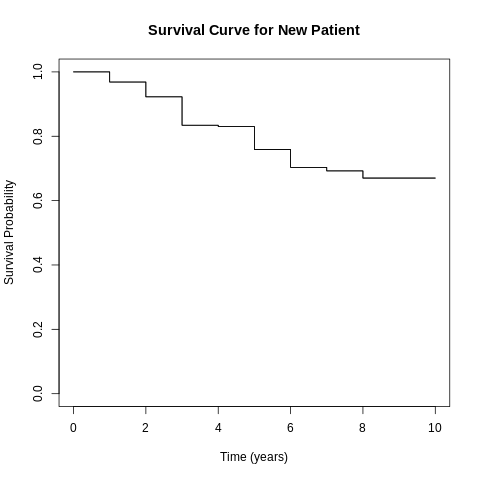

In [13]:
%%R
# Step 8: Example usage
set.seed(123)  # For reproducibility
forest <- rsf(data, n_trees = 10, max_depth = 3, min_node_size = 5)

# Predict survival for a new patient
new_patient <- data.frame(age = 50, sex = 1, thickness = 2.5, ulcer = 0)
times <- seq(0, 10, by = 1)  # Predict survival from 0 to 10 years
prediction <- predict_rsf(forest, new_patient, times)

# Print survival probabilities
print(data.frame(Time = times, Survival = round(prediction$survival, 4)))

# Plot survival curve
plot(prediction$times, prediction$survival, type = "s", xlab = "Time (years)",
     ylab = "Survival Probability", main = "Survival Curve for New Patient", ylim = c(0, 1))
lines(prediction$times, prediction$survival, type = "s")

In [11]:
%%R
# remove all objects
rm(list = ls())

## Random Survival Forest in R


Several R packages support **Random Survival Forests (RSF)** for survival analysis, each with unique features and implementations.
Below is a concise list of the main available R packages for RSF as of my knowledge cutoff, based on their prominence and functionality:

1.  {randomForestSRC}: The most widely used package for RSF, offering a robust and flexible implementation for survival, regression, and classification. It supports survival analysis with censoring, variable importance (VIMP), and prediction metrics like Brier Score and C-index.
    -   **Key Features**:
        -   Handles right-censored data.
        -   Provides ensemble survival/hazard functions.
        -   Supports Brier Score, CRPS, and permutation-based VIMP.
        -   Parallel processing for efficiency.
2.  {ranger} A fast and lightweight package for Random Forests, including survival analysis. It’s optimized for speed and memory efficiency, supporting RSF with log-rank or other splitting rules.
    -   **Key Features**:
        -   High performance with large datasets.
        -   Supports right-censored survival data.
        -   Variable importance and prediction functions.
        -   Integrates with machine learning pipelines.
3.  {DynForest}: A package for dynamic random forests, which can handle time-varying covariates and longitudinal data. It’s particularly useful for survival analysis with time-dependent predictors.
    -   **Key Features**:
        -   Dynamic predictions based on time-varying covariates.
        -   Variable importance for longitudinal and survival data.
        -   Handles right-censored data.


### Check amd Install Required R Packages


Following R packages are required to run this notebook.
If any of these packages are not installed, you can install them using the code below:


In [15]:
%%R
packages <- c('tidyverse',
              'plyr',
              'randomForest',
              'ranger',
              'tuneRanger',
              'randomForestSRC',
              'Metrics',
              'ggpmisc',
              'MASS',
              'survival',
              'riskRegression',
              'DynForest',
              'pec',
              'patchwork',
              'doRNG')


### Install Missing Packages

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')
devtools::install_github("ItziarI/WeDiBaDis", lib='drive/My Drive/R/')


### Verify Installation

In [16]:
%%R
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:


  method                  from   
  heightDetails.titleGrob ggplot2
  widthDetails.titleGrob  ggplot2

  method  from       
  plot.km DiceKriging

  method      from  
  plot.cuminc cmprsk



      tidyverse            plyr    randomForest          ranger      tuneRanger 
           TRUE            TRUE            TRUE            TRUE            TRUE 
randomForestSRC         Metrics         ggpmisc            MASS        survival 
           TRUE            TRUE            TRUE            TRUE            TRUE 
 riskRegression       DynForest             pec       patchwork           doRNG 
           TRUE            TRUE            TRUE            TRUE            TRUE 


### Load Required Libraries

In [19]:
%%R
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))

### Check Loaded Packages

In [17]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])

Successfully loaded packages:
[1] "package:tools"     "package:stats"     "package:graphics" 
[4] "package:grDevices" "package:utils"     "package:datasets" 
[7] "package:methods"   "package:base"     


## Random Survival Forest using {randomForestSRC} package


In this section, we will implement a Random Survival Forest using the `randomForestSRC` package in R. We will use the Melanoma dataset from the `MASS` package, which contains survival data for patients with Melanoma skin cancer.


#### Data


The Melanoma data frame has data on 205 patients in Denmark with malignant Melanoma.
This data frame contains the following columns:

`time` - survival time in days, possibly censored.

`status` - 1 died from Melanoma, 2 alive, 3 dead from other causes.

`sex` - 1 = male, 0 = female.

`age` - age in years.

`year`- year of operation.

`thickness` - tumour thickness in mm.

`ulcer` - 1 = presence, 0 = absence.


In [18]:
%%R
# Load Melanoma dataset from MASS
data(Melanoma, package = "MASS")
glimpse(Melanoma)

Rows: 205
Columns: 7
$ time      <int> 10, 30, 35, 99, 185, 204, 210, 232, 232, 279, 295, 355, 386,…
$ status    <int> 3, 3, 2, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, …
$ sex       <int> 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, …
$ age       <int> 76, 56, 41, 71, 52, 28, 77, 60, 49, 68, 53, 64, 68, 63, 14, …
$ year      <int> 1972, 1968, 1977, 1968, 1965, 1971, 1972, 1974, 1968, 1971, …
$ thickness <dbl> 6.76, 0.65, 1.34, 2.90, 12.08, 4.84, 5.16, 3.22, 12.88, 7.41…
$ ulcer     <int> 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …


#### Prepare data for survival analysis


- `time` is in days, convert to years for interpretability (optional)
- `status` == 1 indicates death from Melanoma (event of interest)
- `status` == 2 indicates censored, 'status' == 3 indicates death from other causes

 We focus on death from Melanoma, treating other deaths as censored Melanoma
 - event <- ifelse(Melanoma$status == 1, 1, 0)  # 1 for event, 0 for censored


In [19]:
%%R
# Prepare data for survival analysis
Melanoma$event <- ifelse(Melanoma$status == 1, 1, 0)  # 1 for event, 0 for censored
Melanoma$time_years <- Melanoma$time / 365.25  # Convert time to years

#### Define Survival Formula


The survival formula for the Random Survival Forest model is defined using the `Surv()` function from the `survival` package. The formula includes the survival time and event status as the response variable, and the predictors (features) of interest.

`time`: Survival time in days.

`status`: 1 (death from Melanoma), 2 (alive/censored), 3 (death from other causes).

`Predictors`: sex, age, year, thickness (tumor thickness), ulcer (presence of ulceration).

We define the event as death from Melanoma (`status == 1`) and treat other cases as `censored`.
Time is converted to years for interpretability.


In [20]:
%%R
# Define survival formula
# Using all available predictors: sex, age, year, thickness, ulcer
formula <- Surv(time_years, event) ~ sex + age + year + thickness + ulcer

In [21]:
%%R
# Convert time from days to years for interpretability
Melanoma$time <- Melanoma$time / 365
# Ensure status is coded as 0 (censored), 1 (Melanoma death), 2 (other death)
Melanoma$status <- as.integer(Melanoma$status)  # 1 = Melanoma death, 2 = other death, 0 = censored
# Select relevant predictors
data <- Melanoma[, c("time", "status", "age", "sex", "thickness", "ulcer")]
# Remove rows with NA in any column to ensure clean data
data <- data[complete.cases(data), ]

#### Fit Random Survival Forest Model


The `rfsrc()` function fits an RSF model with 1000 trees, (`ntree`) a minimum node size (`nodsize`) of 5 events, and 10 random split (`nsplit`) points per variable.
Variable importance is enabled (`importance = TRUE`) for VIMP analysis. The model uses out-of-bag (OOB) data for performance estimation, which is robust for small datasets like Melanoma (n=205). `formula` specifies the survival model with time and event status.


In [22]:
%%R
# Fit Random Survival Forest
set.seed(123)  # For reproducibility
rsf_model <- rfsrc(
  formula,
  data = Melanoma,
  ntree = 1000,        # Number of trees
  nodesize = 5,        # Minimum number of events in terminal nodes
  nsplit = 10,         # Number of random split points
  importance = TRUE,   # Calculate variable importance
  block.size = 1       # For plotting error rate per tree
)
print(rsf_model)

                         Sample size: 205
                    Number of deaths: 57
                     Number of trees: 1000
           Forest terminal node size: 5
       Average no. of terminal nodes: 21.467
No. of variables tried at each split: 3
              Total no. of variables: 5
       Resampling used to grow trees: swor
    Resample size used to grow trees: 130
                            Analysis: RSF
                              Family: surv
                      Splitting rule: logrank *random*
       Number of random split points: 10
                          (OOB) CRPS: 1.25835496
                   (OOB) stand. CRPS: 0.13769148
   (OOB) Requested performance error: 0.28203648



#### Calculate C-index for Model Evaluation


The `C-index (concordance index)` also known as the concordance index or Harrell’s concordance index, is a metric used in survival analysis to evaluate the predictive performance of a model, such as a Random Survival Forest. It measures the model’s ability to correctly rank pairs of individuals based on their survival times, i.e., whether the model predicts a higher risk or shorter survival time for the individual who experiences the event (e.g., death) sooner. The C-index can be calculated as 1 - C-error rate, where C-error rate is the final out-of-bag (OOB) error rate.  Lower C-error (higher C-index) indicates better ranking performance

C-index ranges from 0 to 1:

-   1: Perfect ranking (model correctly orders all pairs).

-   0.5: Random guessing (no predictive power).

-   0: Completely incorrect ranking.
    (no discrimination) to 1 (perfect discrimination).

The C-index is often derived as 1 - prediction error, where the error is the out-of-bag (OOB) prediction error rate (e.g., in randomForestSRC or ranger). For the Melanoma dataset, a C-index of 0.7–0.8 indicates moderate to good ranking performance.


In [23]:
%%R
#  Calculate C-index
c_error <- rsf_model$err.rate[length(rsf_model$err.rate)]  # Final OOB error rate
c_index <- 1 - c_error
cat("C-index:", c_index, "\n")

C-index: 0.7179635 


#### Plotting Survival Forest Results


`plot.survival()` function shows how ensemble survival and individual curves are estimated.
The `cens.model` argument specifies the censoring distribution, which can be "km" (Kaplan-Meier) or "exp" (exponential).
The `plot.survival()` function provides a visual representation of the survival functions estimated by the RSF model.


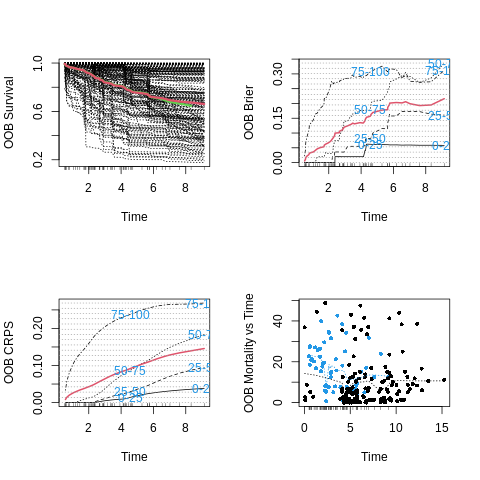

In [24]:
%%R
# Plot Estimated Survival Functions
# Using plot.survival to show ensemble survival and individual curves
plot.survival(
  rsf_model,
  cens.model = "km",  # Kaplan-Meier for censoring distribution
  #xlab = "Time (Years)",
  #ylab = "Survival Probability"
)

#### Predict Survival Functions


Below is an example of how to predict survival functions for hypothetical individuals using the fitted RSF model. We will create two hypothetical individuals with different thickness values (25th and 75th quantiles) while keeping other variables at their median values.


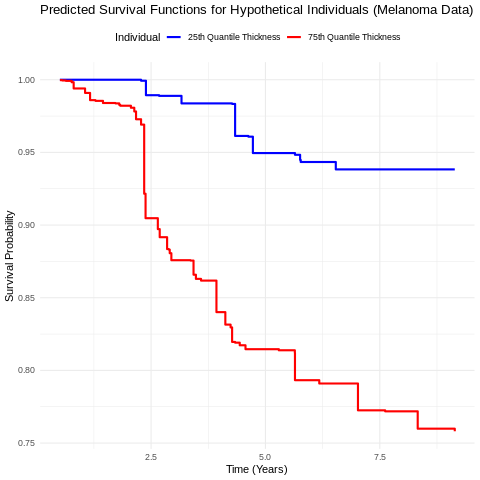

In [25]:
%%R

# Fit Random Survival Forest
set.seed(123)  # For reproducibility
rsf_object <- rfsrc(
  Surv(time_years, event) ~ sex + age + year + thickness + ulcer,
  data = Melanoma,
  ntree = 500,         # Number of trees
  nodesize = 5,        # Minimum events in terminal nodes
  block.size = 1       # For plotting error rate per tree
)

# Create hypothetical individuals
# Calculate median values for all variables and quantiles for thickness
median_values <- sapply(Melanoma[, c("sex", "age", "year", "ulcer")], median)
thickness_quantiles <- quantile(Melanoma$thickness, probs = c(0.25, 0.75))

# Individual 1: thickness at 25th quantile, others at median
ind1 <- data.frame(
  sex = median_values["sex"],
  age = median_values["age"],
  year = median_values["year"],
  thickness = thickness_quantiles[1],  # 25th quantile
  ulcer = median_values["ulcer"]
)

# Individual 2: thickness at 75th quantile, others at median
ind2 <- data.frame(
  sex = median_values["sex"],
  age = median_values["age"],
  year = median_values["year"],
  thickness = thickness_quantiles[2],  # 75th quantile
  ulcer = median_values["ulcer"]
)

# Combine hypothetical individuals
hypothetical_data <- rbind(ind1, ind2)

# Predict survival functions
pred <- predict(rsf_object, newdata = hypothetical_data)

# Extract survival probabilities and time points
surv_probs <- pred$survival  # Survival probabilities for both individuals
times <- pred$time.interest  # Time points

# Create data frame for plotting
plot_data <- data.frame(
  Time = rep(times, 2),
  Survival = c(surv_probs[1, ], surv_probs[2, ]),
  Individual = rep(c("25th Quantile Thickness", "75th Quantile Thickness"), each = length(times))
)

# Plot survival functions using ggplot2
ggplot(plot_data, aes(x = Time, y = Survival, color = Individual)) +
  geom_step(size = 1) +
  labs(
    title = "Predicted Survival Functions for Hypothetical Individuals (Melanoma Data)",
    x = "Time (Years)",
    y = "Survival Probability",
    color = "Individual"
  ) +
  scale_color_manual(values = c("blue", "red")) +
  theme_minimal() +
  theme(legend.position = "top")

#### Plot Brier Scores


The Brier Score measures prediction accuracy at specific time points, accounting for censoring using inverse probability of censoring weights (IPCW) with the `Kaplan-Meier` estimator (`cens.model = "km"`). The Brier Score ranges from 0 to 1, where lower values indicate better predictive accuracy.


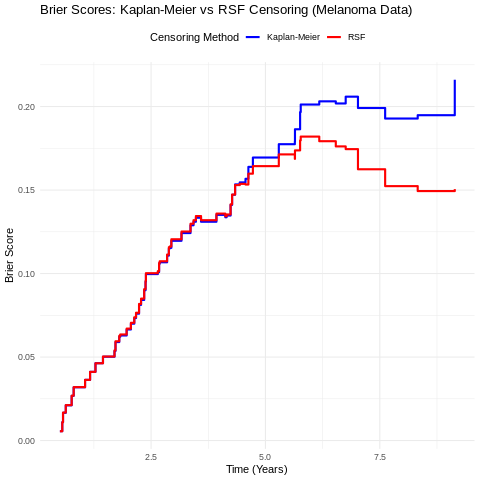

In [26]:
%%R

# Compute Brier Scores
# Kaplan-Meier censoring distribution
bs.km <- get.brier.survival(rsf_model, cens.model = "km")$brier.score
# RSF-based censoring distribution
bs.rsf <- get.brier.survival(rsf_model, cens.model = "rfsrc")$brier.score

# Create data frame for plotting
plot_data <- data.frame(
  Time = rep(rsf_model$time.interest, 2),
  BrierScore = c(bs.km[, 2], bs.rsf[, 2]),  # Second column contains Brier Score
  Method = rep(c("Kaplan-Meier", "RSF"), each = length(rsf_model$time.interest))
)

# Plot Brier Scores using ggplot2
ggplot(plot_data, aes(x = Time, y = BrierScore, color = Method)) +
  geom_step(size = 1) +
  labs(
    title = "Brier Scores: Kaplan-Meier vs RSF Censoring (Melanoma Data)",
    x = "Time (Years)",
    y = "Brier Score",
    color = "Censoring Method"
  ) +
  scale_color_manual(values = c("Kaplan-Meier" = "blue", "RSF" = "red")) +
  theme_minimal() +
  theme(legend.position = "top")

#### Calculate Continuous Rank Probability Score (CRPS)


The Continuous Rank Probability Score (CRPS) is a metric used to evaluate the accuracy of probabilistic forecasts, particularly in survival analysis.
It measures the difference between the predicted and observed survival distributions over time.
The CRPS is calculated as the integrated Brier score divided by the time interval (`t-0`).
The CRPS ranges from 0 to 1, where lower values indicate better predictive accuracy.
The CRPS is particularly useful for evaluating survival models, as it accounts for the entire survival distribution rather than just point estimates.

CRPS at time $t$ is defined as the integral of the Brier Score from $0$ to $t$, divided by the time range ($t - 0$).
The `trapz` function implements the trapezoidal rule to numerically integrate the Brier Score over time.
For each time point, CRPS is computed as:

$$   \text{CRPS}(t) = \frac{\int_0^t \text{Brier}(s) \, ds}{t - 0} $$

-   At $t=0$, CRPS is set to 0 (no prediction error at the start).

-   The `trapezoidal rule` is used to calculate the CRPS by integrating the Brier score over time.
    The CRPS is calculated for both Kaplan-Meier and RSF methods, and the results are plotted for comparison.


CRPS (Kaplan-Meier) at max time: 0.1457704 
CRPS (RSF) at max time: 0.1297188 


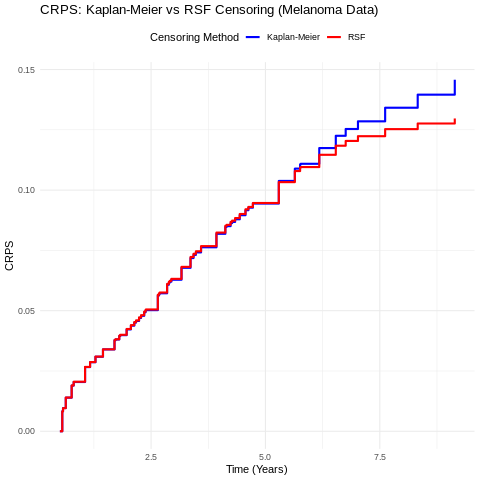

In [27]:
%%R
# Define trapezoidal rule for integration
trapz <- function(x, y) {
  idx <- order(x)
  x <- x[idx]
  y <- y[idx]
  sum(diff(x) * (y[-length(y)] + y[-1]) / 2)
}

# Calculate CRPS for both methods
times <- rsf_model$time.interest
crps.km <- sapply(seq_along(times), function(j) {
  if (j == 1) return(0)  # CRPS is 0 at t=0
  trapz(times[1:j], bs.km[1:j, 2]) / diff(range(times[1:j]))
})
crps.rsf <- sapply(seq_along(times), function(j) {
  if (j == 1) return(0)  # CRPS is 0 at t=0
  trapz(times[1:j], bs.rsf[1:j, 2]) / diff(range(times[1:j]))
})

# Print CRPS at the final time point for both methods
cat("CRPS (Kaplan-Meier) at max time:", crps.km[length(crps.km)], "\n")
cat("CRPS (RSF) at max time:", crps.rsf[length(crps.rsf)], "\n")

# Create data frame for plotting
plot_data <- data.frame(
  Time = rep(times, 2),
  CRPS = c(crps.km, crps.rsf),
  Method = rep(c("Kaplan-Meier", "RSF"), each = length(times))
)

# Plot CRPS using ggplot2
ggplot(plot_data, aes(x = Time, y = CRPS, color = Method)) +
  geom_step(size = 1) +
  labs(
    title = "CRPS: Kaplan-Meier vs RSF Censoring (Melanoma Data)",
    x = "Time (Years)",
    y = "CRPS",
    color = "Censoring Method"
  ) +
  scale_color_manual(values = c("Kaplan-Meier" = "blue", "RSF" = "red")) +
  theme_minimal() +
  theme(legend.position = "top")

#### Variable Importance (VIMP)

In [28]:
%%R
# Variable Importance (VIMP)
# Extract VIMP
vimp <- rsf_model$importance
vimp_df <- data.frame(
  Variable = names(vimp),
  Importance = vimp
)

# Sort by importance
vimp_df <- vimp_df[order(-vimp_df$Importance), ]
# Print VIMP for reference
print(vimp_df)

           Variable   Importance
thickness thickness  0.153622277
ulcer         ulcer  0.104049088
year           year  0.044445705
age             age  0.025908234
sex             sex -0.003712414


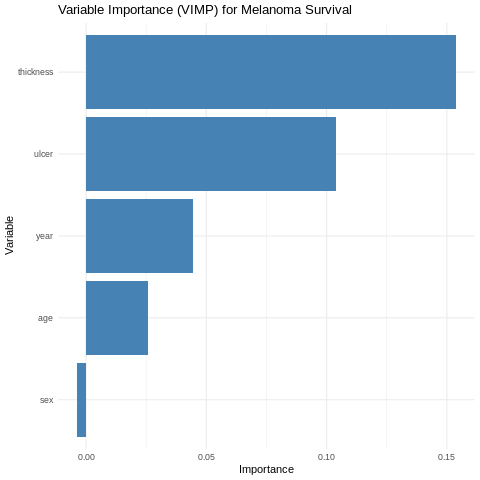

In [29]:
%%R
# Plot VIMP using ggplot2
ggplot(vimp_df, aes(x = reorder(Variable, Importance), y = Importance)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +
  labs(
    title = "Variable Importance (VIMP) for Melanoma Survival",
    x = "Variable",
    y = "Importance"
  ) +
  theme_minimal()



#### Competting Risks


The {randomForestSRC}  package extends random forests to handle competing risks, where multiple event types (e.g., death due to melanoma, death due to other causes) are possible, and right-censoring complicates the analysis. For competing risks, the package estimates:

* `Cause-Specific Cumulative Hazard Function (CSCHF)`: The instantaneous risk of an event type.

* `Cumulative Incidence Function (CIF)`: The probability of an event type occurring by time $t$ acccounting for competing events.

*  `Predicted Values`: The expected number of life years lost due to each event type.

We will rebuild  the RSF Model for  a competing risks , specifying the `Surv` object and appropriate splitting rules (e.g., `logrankCR` for CIF-based splits).



In [30]:
%%R
rsf_model_01 <- rfsrc(
  Surv(time, status) ~ age + sex + thickness + ulcer,
  data = data,
  ntree = 100,           # Number of trees
  nodesize = 15,         # Minimum node size (recommended for competing risks)
  splitrule = "logrankCR",  # Use log-rank splitting for cumulative incidence
  na.action = "na.impute",  # Impute missing values
  importance = TRUE       # Compute variable importance
)

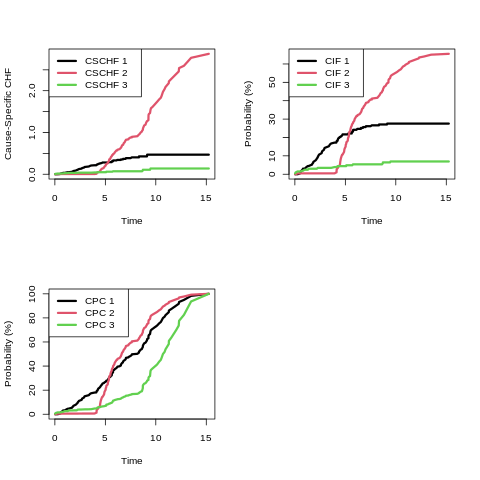

In [31]:
%%R
plot.competing.risk(rsf_model_01)

In [32]:
%%R
# remove all objects from the environment
rm(list = ls())

## Random Survival Forest using {ranger} package


The `{ranger}` package is a fast implementation of Random Forests in R, including support for survival analysis. It is particularly efficient for large datasets and provides various options for tuning and customization. Below is an example of how to implement a Random Survival Forest using the `{ranger}` package.


#### Data

In [33]:
%%R
# Load Melanoma dataset
data(Melanoma, package = "MASS")

#### Prepare Data


-   The Melanoma dataset (n=205) from MASS includes time (days), status (1=death from Melanoma, 2=alive, 3=other death), and predictors (sex, age, year, thickness, ulcer).

-   We define the event as death from Melanoma (status == 1) and treat others as censored.
    Time is converted to years.


In [34]:
%%R
# Prepare data
# Event: 1 = death from Melanoma, 0 = censored (alive or other death)
Melanoma$event <- ifelse(Melanoma$status == 1, 1, 0)
# Convert time to years for interpretability
Melanoma$time_years <- Melanoma$time / 365.25
# Verify that time_years is correctly created
if (all(is.na(Melanoma$time_years))) {
  stop("Error: time_years contains only NA values. Check the 'time' column.")
}
cat("Max time_years:", max(Melanoma$time_years, na.rm = TRUE), "\n")

Max time_years: 15.23614 


#### Define Survival Object

In [35]:
%%R
# Define survival object
surv_obj <- Surv(Melanoma$time_years, Melanoma$event)

#### Fit Random Survival Forest Model


The `ranger()` function fits an RSF with 500 trees and a minimum node size of 5. Permutation-based variable importance is enabled. `keep.inbag = TRUE` allows for out-of-bag (OOB) error calculations.


In [36]:
%%R
# Fit Random Survival Forest with ranger
set.seed(123)  # For reproducibility
rsf_ranger <- ranger(
  formula = Surv(time_years, event) ~ sex + age + year + thickness + ulcer,
  data = Melanoma,
  num.trees = 500,      # Number of trees
  min.node.size = 5,    # Minimum node size
  importance = "permutation",  # Enable variable importance
  keep.inbag = TRUE     # For prediction error calculations
)
rsf_ranger

Ranger result

Call:
 ranger(formula = Surv(time_years, event) ~ sex + age + year +      thickness + ulcer, data = Melanoma, num.trees = 500, min.node.size = 5,      importance = "permutation", keep.inbag = TRUE) 

Type:                             Survival 
Number of trees:                  500 
Sample size:                      205 
Number of independent variables:  5 
Mtry:                             3 
Target node size:                 5 
Variable importance mode:         permutation 
Splitrule:                        logrank 
Number of unique death times:     57 
OOB prediction error (1-C):       0.2883861 


#### Calculate C-index

In [37]:
%%R
# 1. Calculate C-index (via out-of-bag prediction error)
# Ranger uses 1 - error rate as a proxy for C-index
c_index <- 1 - rsf_ranger$prediction.error
cat("C-index:", c_index, "\n")

C-index: 0.7116139 


#### Predict survival probabilities at specified times

In [38]:
%%R
# Predict survival probabilities at specified times
# Define time points for prediction
times <- seq(0, max(Melanoma$time_years, na.rm = TRUE), length.out = 100)
# ranger does not directly support custom time points, so we approximate
pred <- predict(rsf_ranger, data = Melanoma)
available_times <- pred$unique.death.times  # Time points from ranger predictions
surv_probs <- exp(-pred$chf)  # Convert cumulative hazard to survival probabilities

# Interpolate survival probabilities to match 'times'
surv_probs_interpolated <- matrix(NA, nrow = nrow(surv_probs), ncol = length(times))
for (i in 1:nrow(surv_probs)) {
  surv_probs_interpolated[i, ] <- approx(
    x = available_times,
    y = surv_probs[i, ],
    xout = times,
    method = "linear",
    rule = 2
  )$y
}

# Compute ensemble survival function
ensemble_surv <- colMeans(surv_probs_interpolated)  # Average across individuals

# Create data frame for plotting
surv_df <- data.frame(
  Time = times,
  Survival = ensemble_surv
)

# Verify dimensions
cat("Length of Time:", length(times), "\n")
cat("Length of Survival:", length(ensemble_surv), "\n")

Length of Time: 100 
Length of Survival: 100 


#### Plot Ensemble Survival Function

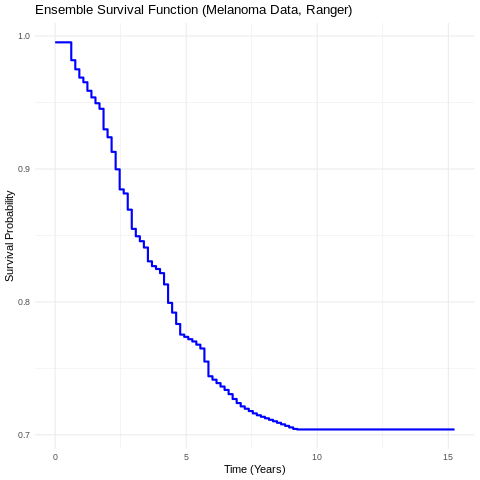

In [39]:
%%R
# Plot ensemble survival function
ggplot(surv_df, aes(x = Time, y = Survival)) +
  geom_step(size = 1, color = "blue") +
  labs(
    title = "Ensemble Survival Function (Melanoma Data, Ranger)",
    x = "Time (Years)",
    y = "Survival Probability"
  ) +
  theme_minimal()

#### Calculate Brier Score


The Brier Score is a measure of the accuracy of probabilistic predictions. It is calculated as the mean squared difference between predicted probabilities and observed outcomes.
The Brier Score ranges from 0 to 1, where lower values indicate better predictive accuracy. The Brier Score can be computed using the `{riskRegression}` package, which provides functions for survival analysis and risk prediction.


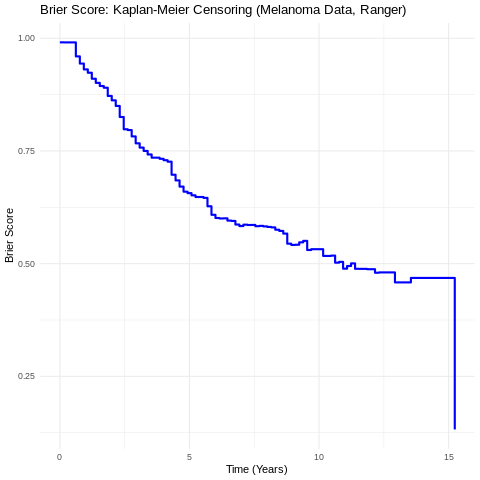

In [40]:
%%R
# Compute Brier Score using riskRegression
brier <- riskRegression::Score(
  list("Ranger" = surv_probs_interpolated),
  formula = Surv(time_years, event) ~ 1,
  data = Melanoma,
  times = times,
  cens.model = "km",  # Kaplan-Meier censoring
  metrics = "brier"
)

# Extract Brier Scores
brier_scores <- brier$Brier$score[brier$Brier$score$model == "Ranger", "Brier"]

# Create data frame for plotting
plot_data <- data.frame(
  Time = times,
  BrierScore = brier_scores
)

# Plot Brier Score
ggplot(plot_data, aes(x = Time, y = Brier)) +
  geom_step(size = 1, color = "blue") +
  labs(
    title = "Brier Score: Kaplan-Meier Censoring (Melanoma Data, Ranger)",
    x = "Time (Years)",
    y = "Brier Score"
  ) +
  theme_minimal()

#### Calculate Continuous Rank Probability Score (CRPS)

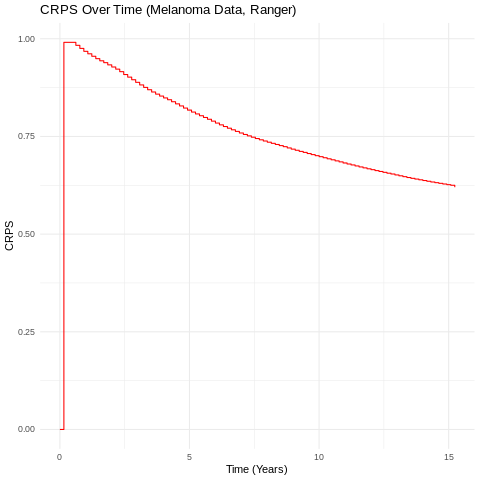

In [41]:
%%R
# Calculate CRPS (Integrated Brier Score / Time)
trapz <- function(x, y) {
  idx <- order(x)
  x <- x[idx]
  y <- y[idx]
  sum(diff(x) * (y[-length(y)] + y[-1]) / 2)
}
crps <- sapply(seq_along(times), function(j) {
  if (j == 1) return(0)
  trapz(times[1:j], brier_scores[1:j]) / diff(range(times[1:j]))
})
crps_df <- data.frame(Time = times, CRPS = crps)
ggplot(crps_df, aes(x = Time, y = CRPS)) +
  geom_step(color = "red") +
  labs(
    title = "CRPS Over Time (Melanoma Data, Ranger)",
    x = "Time (Years)",
    y = "CRPS"
  ) +
  theme_minimal()

#### Feature Importance (VIMP)

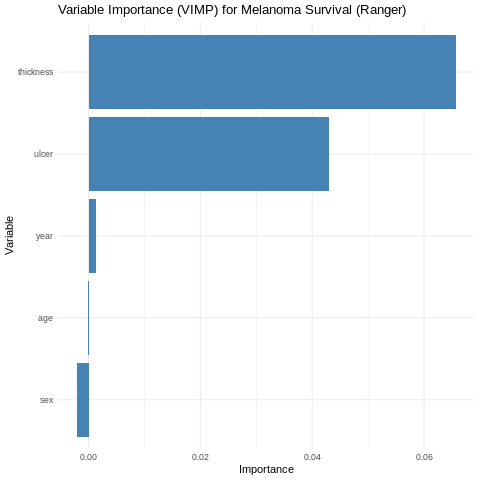

In [42]:
%%R
#  Variable Importance
vimp <- rsf_ranger$variable.importance
vimp_df <- data.frame(
  Variable = names(vimp),
  Importance = vimp
)
vimp_df <- vimp_df[order(-vimp_df$Importance), ]

# Plot VIMP
ggplot(vimp_df, aes(x = reorder(Variable, Importance), y = Importance)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +
  labs(
    title = "Variable Importance (VIMP) for Melanoma Survival (Ranger)",
    x = "Variable",
    y = "Importance"
  ) +
  theme_minimal()

# Print VIMP


In [ ]:
%%R
# remove all objects from the environment
rm(list = ls())

## Random Survival Forest using {DynForest} package


The {DynForest} package is designed for dynamic random forests, particularly for longitudinal or time-dependent predictors with survival outcomes. It allows for the modeling of time-varying covariates and is suitable for survival analysis with complex data structures.  Below is an example of how to implement a Random Survival Forest using the {DynForest} package. In this section we mostly follow the example from the [package documentation](https://cran.r-project.org/web/packages/DynForest/vignettes/survival.html).


#### Data


We will use the `pbc2` dataset from the `DynForest` package, which contains survival data for patients with primary biliary cirrhosis (PBC).
The dataset includes time-to-event data, censoring information, and various clinical predictors.
This Longitudinal dataset with 1945 rows and 19 columns for 312 patients with primary biliary cirrhosis (PBC) includes time-to-event data, censoring information, and various clinical predictors.
The dataset contains the following columns:

`id`: Patient identifier

`time`: Time measurement

`ascites` : Presence of ascites (Yes/No)

`hepatomegaly`: Presence of hepatomegaly (Yes/No)

`spiders`: Blood vessel malformations in the skin (Yes/No)

`edema`: Edema levels (No edema/edema no diuretics/edema despite diuretics)

`serBilir`: Level of serum bilirubin

`serChol`: Level of serum cholesterol

`albumin`: Level of albumin

`alkaline`: Level of alkaline phosphatase

`SGOT`: Level of aspartate aminotransferase

`platelets`: Platelet count

`prothrombin`: Prothrombin time

`histologic`: Histologic stage of disease

`drug`: Drug treatment (D-penicillmain/Placebo)

`age`:Age at enrollment

`sex`: Sex of patient

`years`: Time-to-event in years

`event`:Event indicator: 0 (alive), 1 (transplanted) and 2 (dead)


In [20]:
%%R
# Load Melanoma dataset
data(pbc2, package = "DynForest")
glimpse(pbc2)

Rows: 1,945
Columns: 19
$ id           <dbl> 1, 1, 10, 100, 100, 100, 100, 101, 101, 101, 101, 101, 10…
$ time         <dbl> 0.0000000, 0.5256817, 0.0000000, 0.0000000, 0.4681853, 0.…
$ ascites      <fct> Yes, Yes, Yes, No, No, Yes, NA, No, No, No, No, No, No, N…
$ hepatomegaly <fct> Yes, Yes, No, Yes, Yes, No, NA, No, Yes, Yes, No, Yes, Ye…
$ spiders      <fct> Yes, Yes, Yes, No, No, No, NA, No, No, Yes, No, No, No, N…
$ edema        <fct> edema despite diuretics, edema despite diuretics, edema d…
$ serBilir     <dbl> 14.5, 21.3, 12.6, 2.3, 2.5, 2.9, 4.4, 0.9, 1.1, 0.9, 0.7,…
$ serChol      <int> 261, NA, 200, 178, NA, NA, NA, 400, NA, NA, 317, NA, NA, …
$ albumin      <dbl> 2.60, 2.94, 2.74, 3.00, 2.94, 3.02, 2.20, 3.60, 3.54, 3.2…
$ alkaline     <int> 1718, 1612, 918, 746, 836, 650, NA, 1689, 1558, 1736, 149…
$ SGOT         <dbl> 138.0, 6.2, 147.3, 178.3, 189.1, 124.0, 124.0, 164.3, 133…
$ platelets    <int> 190, 183, 302, 119, 98, 99, NA, 327, 409, 283, 358, 312, …
$ prothrombin  <

#### Split Data

In [21]:
%%R
# split the data into training and test sets
set.seed(1234)
id <- unique(pbc2$id)
id_sample <- sample(id, length(id)*2/3)
id_row <- which(pbc2$id %in% id_sample)
train <- pbc2[id_row,]
test <- pbc2[-id_row,]

#### Prepare training data


First, we create the dataframe `time_train` in a longitudinal format, meaning there is one observation per row. This dataframe includes the following longitudinal predictors: `id`, the unique patient identifier; `time`, the observed time measurements; and the variables `serBilir`, `SGOT`, `albumin`, and `alkaline`.

Next, we build the dataframe `fixed_train` containing the time-fixed predictors. This dataframe includes the `id` for the unique patient identifier, as well as the `age`, `drug`, and `sex` predictors measured at enrollment. It is important to correctly define the nature of each predictor using the `as.factor()` function for categorical predictors, such as `drug` and `sex`).


In [22]:
%%R
# Prepare training data
time_train <- train[,c("id",
                       "time",
                        "serBilir",
                        "SGOT",
                        "albumin",
                       "alkaline")]

fixed_train <- unique(train[,c("id",
                               "age",
                               "drug",
                               "sex")])

#### Model of the Time-dependent Predictors


The first step in building a random forest involves specifying the mixed model for each longitudinal predictor. This is done by creating a list that includes both the fixed formula and the random formula for the fixed and random effects of the mixed models, respectively.

In this example, we assume a linear trajectory for `serBilir`, `albumin`, and `alkaline`, while we consider a quadratic trajectory for `SGOT`.
Although this example is limited to linear and quadratic functions of time, it's important to note that other functions, including splines, can also be used.


In [23]:
%%R
timeVarModel <- list(serBilir = list(fixed = serBilir ~ time,
                                     random = ~ time),
                     SGOT = list(fixed = SGOT ~ time + I(time^2),
                                 random = ~ time + I(time^2)),
                     albumin = list(fixed = albumin ~ time,
                                    random = ~ time),
                     alkaline = list(fixed = alkaline ~ time,
                                     random = ~ time))

#### Define Survival Object


The outcome object includes a list with the `type` set to `surv` (indicating survival data). The `Y` component contains a dataframe in wide format, where each row represents one subject. The dataframe includes the following columns: `id`, which is the unique patient identifier; `years`, which holds the time-to-event data; and `event`, which indicates whether the event occurred.


In [24]:
%%R
Y <- list(type = "surv",
          Y = unique(train[,c("id",
                              "years",
                              "event")]))

#### Fit Random Survival Forest Model


- `dynforest()` function fits a random survival forest model using the training data.
-  `timeData` argument specifies the longitudinal data, while the `fixedData` argument specifies the fixed data.
- `timeVar` argument indicates the time variable, and the `idVar` argument specifies the unique patient identifier.
-  `Y` argument contains the outcome object.

The model is built with 200 trees (`ntree`), a minimum node size of 2 (`nodesize`), and a minimum split size of 3 (`minsplit`). The `cause` argument is set to 2, indicating that we are interested in the second event type (death). The `ncores` argument specifies the number of cores to use for parallel processing, and the `seed` argument ensures reproducibility.


In [25]:
%%R
dynf_model <- dynforest(timeData = time_train,
                     fixedData = fixed_train,
                     timeVar = "time",
                     idVar = "id",
                     timeVarModel = timeVarModel,
                     Y = Y,
                     ntree = 200,
                     mtry = 3,
                     nodesize = 2,
                     minsplit = 3,
                     cause = 2,
                     ncores = 7,
                     seed = 1234)

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=39m 03s


In [26]:
%%R
summary(dynf_model)

dynforest executed for survival (competing risk) outcome 
	Splitting rule: Fine & Gray statistic test 
	Out-of-bag error type: Integrated Brier Score 
	Leaf statistic: Cumulative incidence function 
---------------- 
Input 
	Number of subjects: 208 
	Longitudinal: 4 predictor(s) 
	Numeric: 1 predictor(s) 
	Factor: 2 predictor(s) 
---------------- 
Tuning parameters 
	mtry: 3 
	nodesize: 2 
	minsplit: 3 
	ntree: 200 
---------------- 
---------------- 
dynforest summary 
	Average depth per tree: 6.62 
	Average number of leaves per tree: 27.68 
	Average number of subjects per leaf: 4.78 
	Average number of events of interest per leaf: 1.95 
---------------- 
Computation time 
	Number of cores used: 7 
	Time difference of 40.37838 mins
---------------- 


#### Calculate Out-Of-Bag (OOB) Error


The Out-Of-Bag (OOB) error is used to evaluate the predictive performance of a random forest model. For survival outcomes, the OOB error is assessed using the Integrated Brier Score (IBS). This score can be calculated using the `compute_ooberror()` function, which requires an object of class `dynforest` as its main argument. The OOB error is calculated as the mean squared difference between the predicted survival probabilities and the observed outcomes, averaged over all trees in the forest. The OOB error provides an estimate of the model's predictive accuracy and can be used to compare different models or tuning parameters.


In [27]:
%%R
# Calculate Out-Of-Bag (OOB) error
oob_error <- compute_ooberror(dynf_model)
oob_error

[1] 0.1265556


#### Individual prediction of the outcome on test set


The `predict()` function enables users to forecast outcomes for new subjects using a trained random forest model. It requires individual data: time-dependent predictors in `timeData` and time-fixed predictors in `fixedData`. For survival outcomes, users can set a landmark time (`t0`) to generate dynamic predictions based on the individual's history up to that point. If `t0` is set to 0, only data from that initial time is used.

We will select subjects at risk at the 4-year landmark time, create a dataframe for them, and use the `predict()` function to forecast their individual-specific cumulative incidence function (CIF).


In [28]:
%%R
# Select subjects at risk at the 4-year landmark time
id_test <- unique(test$id[which(test$years>4)])
# Create a dataframe for the selected subjects
test_tLM <- test[which(test$id %in% id_test),]
# Create a  time-dependent dataframe
time_test <- test_tLM[,c("id",
                         "time",
                          "serBilir",
                          "SGOT",
                          "albumin",
                          "alkaline")]
# Create a time-fixed dataframe
fixed_test <- unique(test_tLM[,c("id",
                                 "age",
                                 "drug",
                                 "sex")])
# prediction of the outcome
dynf_pred <- predict(object = dynf_model,
                    timeData = time_test,
                    fixedData = fixed_test,
                    idVar = "id",
                    timeVar = "time",
                    t0 = 4)

#### Plot Predicted Cumulative Incidence (CIF)


The `predict()` function returns a list containing the predicted survival probabilities for each individual at the specified time points. the `plot()` function can be used to display the CIF of the outcome (here death before transplantation) for subjects indicated with argument id. For instance, we compute the CIF for subjects 102 and 260 with the following code and display


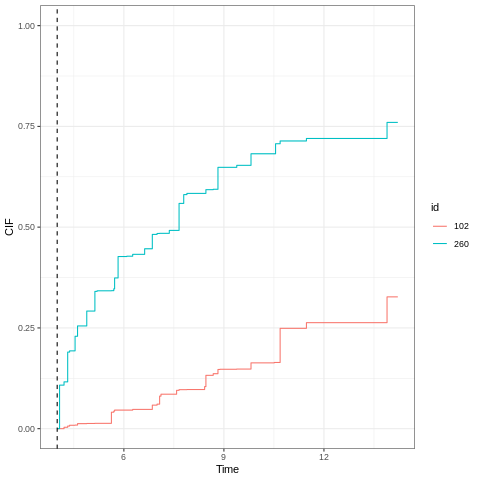

In [29]:
%%R
# Plot CIF for subjects 102 and 260
plot(dynf_pred, id = c(102, 260))

#### Feature Importance


The `compute_vimp()` function calculates variable importance (VIMP) for the random survival forest model. VIMP quantifies the contribution of each predictor to the model's predictive performance. It is computed by permuting the values of each predictor and measuring the increase in prediction error. Higher VIMP values indicate greater importance of the predictor in the model.

`compute_vimp()` function returns the VIMP statistic for each predictor, which is included in the `$Importance` element. You can also display these results using the `plot()` function, which shows the values in absolute terms by default. If you prefer to see the values as a percentage, set the `PCT` argument to `TRUE`.


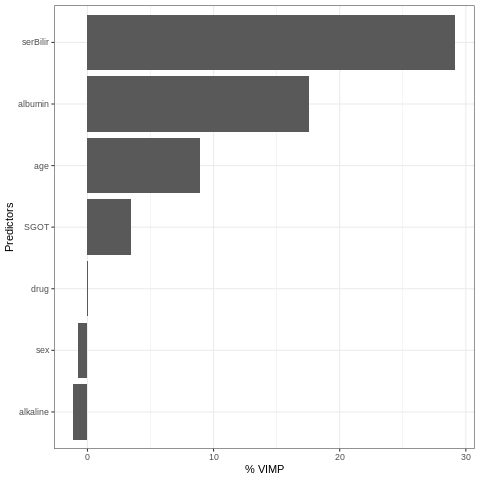

In [30]:
%%R
dynf_model_VIMP <- compute_vimp(dynf_model, seed = 123)
p1<-plot(dynf_model_VIMP, PCT = TRUE)



When predictors are correlated, they can be organized into dimensions, enabling the calculation of the Variable Importance Metric (VIMP) at the group level using the `gVIMP` statistic. The `compute_gvimp()` function performs this calculation, with the `group` argument specifying the predictor groups. For instance, if there are two groups named `group1` and `group2`, the `gVIMP` statistic can be computed as follows:


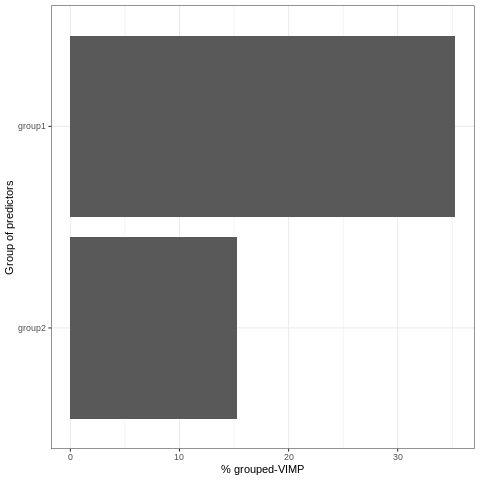

In [31]:
%%R
# Compute gVIMP
group <- list(group1 = c("serBilir","SGOT"),
              group2 = c("albumin","alkaline"))
dynf_model_gVIMP <- compute_gvimp(dynf_model,
                               group = group,
                               seed = 123)
p2 <- plot(dynf_model_gVIMP, PCT = TRUE)

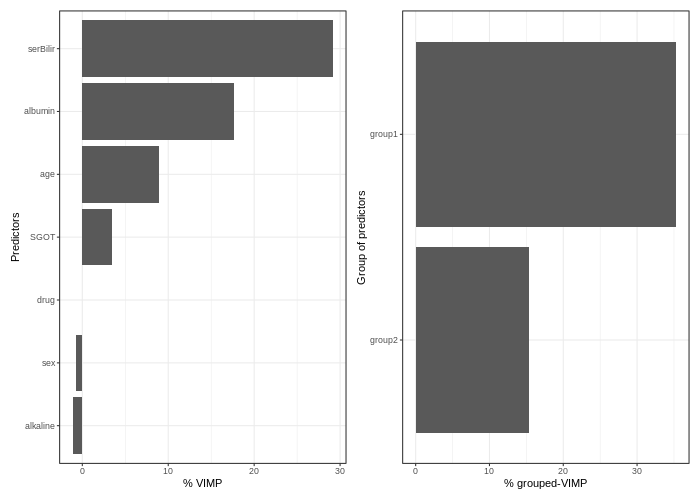

In [36]:
%%R -w 700 -h 500 -u px
p1+ p2

#### Minimal Depth


The `compute_min_depth()` function calculates the minimal depth of each predictor in the random survival forest model. Minimal depth is a measure of how deep a predictor appears in the trees of the forest. Predictors that appear higher in the trees (i.e., with lower minimal depth) are considered more important for making predictions.

It shows the average minimal depth for each feature (`$min_depth`), the minimal depth for each feature and tree (`$var_node_depth`), and how often each feature is used for splits (`$var_count`). We can use the output from `compute_vardepth()` with the `plot()` function to visualize the average minimal depth. The `plot_level` argument allows you to display the depth by predictor or feature


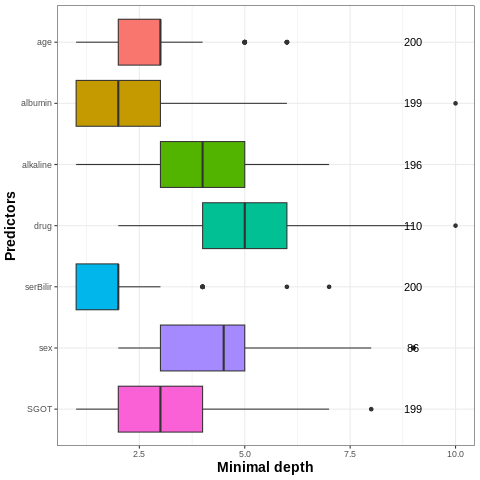

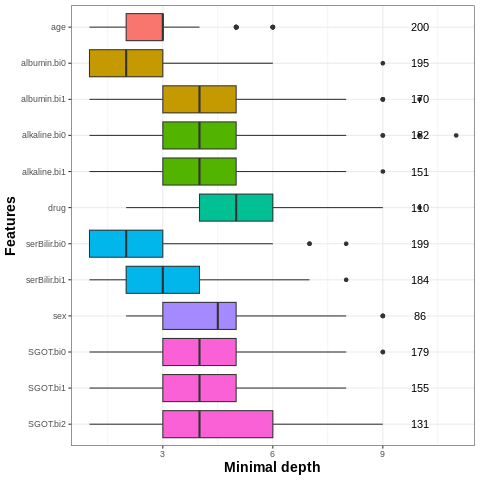

In [37]:
%%R
depth_dynf <- compute_vardepth(dynforest_obj = dynf_model)
p3 <- plot(depth_dynf, plot_level = "predictor")
p4 <- plot(depth_dynf, plot_level = "feature")

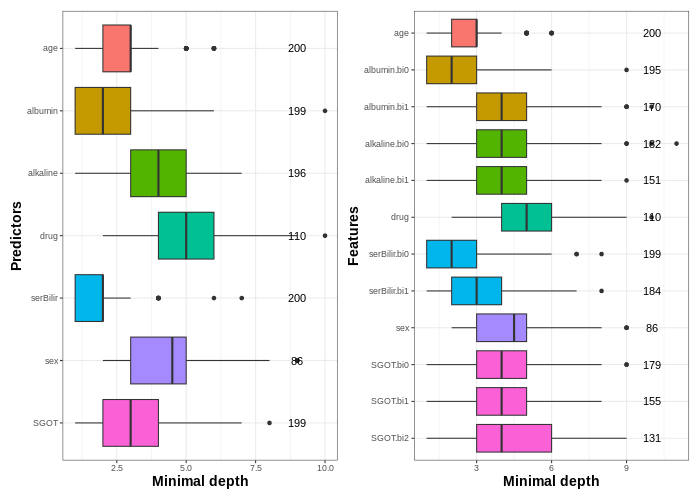

In [39]:
%%R -w 700 -h 500 -u px
p3+p4

## Summary and Conclusion


A Survival Forest is a powerful, non-parametric machine learning model for survival analysis, extending Random Forests to handle time-to-event data with censoring.It builds multiple decision trees using survival-specific splitting criteria, aggregates their predictions, and outputs survival probabilities or hazard functions. It’s widely used in fields like medicine and engineering but requires computational resources and careful tuning. This tutorial demonstrated how to implement Survival Forests in R using the `randomForestSRC`, `ranger`, and `DynForest` packages, covering data preparation, model fitting, evaluation metrics (C-index, Brier Score, CRPS), variable importance, and visualization techniques. This help researchers and practitioners effectively apply Survival Forests to their survival analysis tasks.


## References


1. Ishwaran, H., et al. (2008). Random survival forests. *The Annals of Applied Statistics*, 2(3), 841–860. DOI: 10.1214/08-AOAS169.

2.  Gerds, T. A., & Schumacher, M. (2006). Consistent Estimation of the Expected Brier Score. *Biometrical Journal*, 48(6), 1029–1040. DOI: 10.1002/bimj.200610301.

3.   “randomForestSRC: random survival forests vignette.” http://randomforestsrc.org/articles/survival.html.

4.  [How to use DynForest with survival outcome](https://cran.r-project.org/web/packages/DynForest/vignettes/survival.html)